# DIVAnd analysis using the sample data set

* First follow the installation instruction at https://gher-ulg.github.io/Diva-Workshops/installation.html
* This example makes a salinity analysis using data from the Black Sea
* The analysis is done for every season and year (using all data with 10-year sliding windows form the same season) 

* For testing pruposes, let's start with a low resolution
* A slightly large test case:
    * horizontal resolution of 0.1 degree for the Black Sea
    * 51 depths levels
    * 8 time instance
    * fixed correlation length
    * CPU time: 21 minutes
    * CPU time increases linearly with the number of time instance

Load the modules

In [1]:
using divand
using PyPlot
using NCDatasets
using DataStructures

# Load a more efficient version of sparse matrix multiplication
include(joinpath(Pkg.dir("divand"),"src","override_ssmult.jl"))

Download the file `Salinity.bigfile` (if it is not already present). It will be placed in the same directory as this notebook. This file based on the World Ocean Database.

In [2]:
fname = "Salinity.bigfile"

if !isfile(fname)
    download("https://b2drop.eudat.eu/s/Bv9Fj0YGC0zp2vn/download",fname)
else
    info("Data file already downloaded")
end

INFO: Data file already downloaded


Download the bathymetry if it is not already present

In [3]:
bathname = "gebco_30sec_16.nc"

if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/o0vinoQutAC7eb0/download",bathname)
else
    info("Bathymetry file already downloaded")
end

bathisglobal = true

INFO: Bathymetry file already downloaded


true

Load the data which is here a simple text file with the following columns

| longitude | latitude | value | depth | flag | year | month | day | hour | time string | identifier | bottom depth |
|----------:|---------:|------:|------:|-------:|------:|-----:|-----|------:|-------:|-------:|-------:|
| 28.3333 | 43.167 | 15.7020 | 0.0 | 0 | 1991 | 09 | 03 | 16 | 1991-09-03T16:25 | Cruise:WOD05_BG000003-11570900-28.3333-43.167 | 36 | 
| 28.3333 | 43.167 | 15.7380 | 10.0 | 0 | 1991 | 09 | 03 | 16 | 1991-09-03T16:25 | Cruise:WOD05_BG000003-11570900-28.3333-43.167 | 36 |

Only longitude, latitude, depth, time and the values are used.

In [4]:
value,lon,lat,depth,time,ids = loadbigfile(fname);
@show size(value)

size(value) = (139230,)


(139230,)

The file contains about 140000 measurements.     
Print some basic statistics about the data. Keep an eye on the ranges.

In [5]:
checkobs((lon,lat,depth,time),value,ids)

              minimum and maximum of obs. dimension 1: (27.1005, 41.65)
              minimum and maximum of obs. dimension 2: (40.517, 47.272)
              minimum and maximum of obs. dimension 3: (0.0, 2000.0)
              minimum and maximum of obs. dimension 4: (1977-03-27T04:00:00, 2006-12-15T09:52:00)
                          minimum and maximum of data: (0.0, 38.6573)


Define the resolution. It is recommended to start with a low resolution and increase the resolution when the results are suitable.

In [6]:
dx = 0.2 # longitude resolution in degrees
dy = 0.2 # latitude resolution in degrees

0.2

In [67]:
#dx = 0.1 # longitude resolution in degrees
#dy = 0.1 # latitude resolution in degrees

Define bounding box spatial domain

In [7]:
lonr = 27.:dx:42.; # the range of longitudes (start:step:end)
latr = 40.:dy:47.; # the range of latitudes (start:step:end)

Define the depth levels

In [8]:
depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000]


# or for testing just a few levels
depthr = [0.,20.,50.]

@show size(depthr);

size(depthr) = (3,)


The error variance of the observation (scaled by the error variance of the background).    
Note that this is the inverse of the signal-to-noise ratio used in the 2D version of `DIVA`.

In [9]:
epsilon2 = 0.01

0.01

* Correlation length in meters (in x, y, and z directions)
* 200_000. is the same as 200000., but the former is easier to read

In [10]:
sz = (length(lonr),length(latr),length(depthr))

lenx = fill(200_000.,sz)
leny = fill(200_000.,sz)
lenz = [10+depthr[k]/15 for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]];

Year range and averaging time window

In [11]:
years = 1993:1994

year_window = 10

# winter: January-March    1,2,3
# spring: April-June       4,5,6
# summer: July-September   7,8,9
# autumn: October-December 10,11,12

monthlists = [
    [1,2,3],
    [4,5,6],
    [7,8,9],
    [10,11,12]
];

* Other possible choises for the time selector are `TimeSelectorYearListMonthList` and `TimeSelectorRunningAverage`.
* Type `?` followed by these functions

In [12]:
?TimeSelectorYW

search: TimeSelectorYW TimeSelectorYearListMonthList TimeSelectorRunningAverage



```
TS = TimeSelectorYW(years,yearwindow,monthlists)
```

The structure `TS` handles the time aggregation based on `years` and `monthlists`. It is similar to `TimeSelectorYearListMonthList` except that the elements of `yearlists` are centred around `years` and span `yearwindow` years. `yearlists` is in fact constructed by adding and subtracting `yearwindow/2` to every element of years.


In [13]:
TS = TimeSelectorYW(years,year_window,monthlists)

varname = "Salinity"

# File name based on the variable (but all spaces are replaced by _)
filename = "Water_body_$(replace(varname,' ','_')).4Danl.nc"

# Time origin for the NetCDF file
timeorigin = DateTime(1900,1,1,0,0,0)

# Extract the bathymetry for plotting
bx,by,b = extract_bath(bathname,bathisglobal,lonr,latr);

A list of all metadata

In [36]:
metadata = OrderedDict(
    # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-Chemistry, ...)
    "project" => "SeaDataCloud",

    # URN code for the institution EDMO registry,
    # e.g. SDN:EDMO::1579
    "institution_urn" => "SDN:EDMO::1579",

    # Production group
    #"production" => "Diva group",

    # Name and emails from authors
    "Author_e-mail" => ["Your Name1 <name1@example.com>", "Other Name <name2@example.com>"],

    # Source of the observation
    "source" => "observational data from SeaDataNet/EMODNet Chemistry Data Network",

    # Additional comment
    "comment" => "...",

    # SeaDataNet Vocabulary P35 URN
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
    # example: SDN:P35::WATERTEMP
    "parameter_keyword_urn" => "SDN:P35::EPC00001",

    # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
    # example: ["SDN:P02::TEMP"]
    "search_keywords_urn" => ["SDN:P02::PSAL"],

    # List of SeaDataNet Vocabulary C19 area URNs
    # SeaVoX salt and fresh water body gazetteer (C19)
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
    # example: ["SDN:C19::3_1"]
    "area_keywords_urn" => ["SDN:C19::3_3"],

    "product_version" => "1.0",
    
    "product_code" => "something-to-decide",
    
    # bathymetry source acknowledgement
    # see, e.g.
    # * EMODnet Bathymetry Consortium (2016): EMODnet Digital Bathymetry (DTM).
    # http://doi.org/10.12770/c7b53704-999d-4721-b1a3-04ec60c87238
    # 
    # taken from
    # http://www.emodnet-bathymetry.eu/data-products/acknowledgement-in-publications
    #
    # * The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003
    #
    # taken from
    # https://www.bodc.ac.uk/projects/data_management/international/gebco/gebco_digital_atlas/copyright_and_attribution/
        
    "bathymetry_source" => "The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

    # NetCDF CF standard name
    # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
    # example "standard_name" = "sea_water_temperature",
    "netcdf_standard_name" => "sea_water_salinity",

    "netcdf_long_name" => "sea water salinity",

    "netcdf_units" => "1e-3",

    # Abstract for the product
    "abstract" => "...",

    # This option provides a place to acknowledge various types of support for the
    # project that produced the data
    "acknowledgement" => "...",

    "documentation" => "http://dx.doi.org/doi_of_doc",

    # Digital Object Identifier of the data product
    "doi" => "...")

DataStructures.OrderedDict{String,Any} with 18 entries:
  "project"               => "SeaDataCloud"
  "institution_urn"       => "SDN:EDMO::1579"
  "Author_e-mail"         => String["Your Name1 <name1@example.com>", "Other Na…
  "source"                => "observational data from SeaDataNet/EMODNet Chemis…
  "comment"               => "..."
  "parameter_keyword_urn" => "SDN:P35::EPC00001"
  "search_keywords_urn"   => String["SDN:P02::PSAL"]
  "area_keywords_urn"     => String["SDN:C19::3_3"]
  "product_version"       => "1.0"
  "product_code"          => "something-to-decide"
  "bathymetry_source"     => "The GEBCO Digital Atlas published by the British …
  "netcdf_standard_name"  => "sea_water_salinity"
  "netcdf_long_name"      => "sea water salinity"
  "netcdf_units"          => "1e-3"
  "abstract"              => "..."
  "acknowledgement"       => "..."
  "documentation"         => "http://dx.doi.org/doi_of_doc"
  "doi"                   => "..."

* Make the NetCDF global and variable attributes based on the metadata.
* Custom attributes can be added by changing `ncglobalattrib`:

```julia
ncglobalattrib["attribute_name"] = "attribute_value"
```


In [15]:
ncglobalattrib,ncvarattrib = SDNMetadata(metadata,filename,varname,lonr,latr)

(DataStructures.OrderedDict("project"=>"SeaDataCloud","institution"=>"University of Liege, GeoHydrodynamics and Environment Research","institution_urn"=>"SDN:EDMO::1579","Author_e-mail"=>"Your Name1 <name1@example.com>, Other Name <name2@example.com>","source"=>"observational data from SeaDataNet/EMODNet Chemistry Data Network","comment"=>"...","parameter_keyword"=>"Water body salinity","parameter_keyword_urn"=>"SDN:P35::EPC00001","search_keywords"=>"Salinity of the water column","search_keywords_urn"=>"SDN:P02::PSAL"…), DataStructures.OrderedDict("units"=>"1e-3","standard_name"=>"sea_water_salinity","long_name"=>"sea water salinity"))

Plot the results the surface for debugging and quick inspection.

To generate the plots, we define a function `plotres` (see next cell) that will be used as an optional argument when we call the interpolation with `DIVAnd`.

In [18]:
function plotres_timeindex(timeindex,sel,fit,erri)
@show timeindex
end

plotres_timeindex (generic function with 1 method)

In [19]:
function plotres(timeindex,sel,fit,erri)
    tmp = copy(fit)
    tmp[erri .> .5] = NaN;
    figure(figsize = (10,8))
    subplot(2,1,1)
    title("$(timeindex) - surface")
    
    # select the data near the surface
    selsurface = sel .& (depth .< 5)
    vmin = minimum(value[selsurface])
    vmax = maximum(value[selsurface])
    
    # plot the data
    scatter(lon[selsurface],lat[selsurface],10,value[selsurface];
            vmin = vmin, vmax = vmax)
    xlim(minimum(lonr),maximum(lonr))
    ylim(minimum(latr),maximum(latr))
    colorbar()
    contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])
    
    # plot the analysis
    subplot(2,1,2)
    pcolor(lonr,latr,tmp[:,:,1]';
           vmin = vmin, vmax = vmax)
    colorbar()
    contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])
end

plotres (generic function with 1 method)

Launch the analysis. Plotting can be disabled by commenting the line containing `plotres`.

Here we use `diva3d`, which performs a series of 3D analyses (lon, lat and depth) for the different periods defined previously.

In [21]:
?diva3d

search: diva3d divand_filter3



```
residuals = diva3d(xi,x,value,len,epsilon2,filename,varname)
```

Create a 3D analysis (or a series of 3D analyses) with DIVAnd using the observations `value` (vector) at the locations `x` (tuple of vector) onto the regular grid defined by the vectors `xi` using the scaled obs. error variance  `epsilon2` and the correlation length `len`. The result will be saved in the NetCDF file `filename` under the variable `varname`.

## Inputs

  * `xi`: tuple with n elements. Every element represents a coordinate of the final grid on which the observations are interpolated
  * `x`: tuple with n elements. Every element represents a coordinate of the observations
  * `value`: value of the observations
  * `len`: tuple with n elements. Every element represents the correlation length.  If `fitcorrlen`, then `len` can be the emply tuple `()` or a tuple containing  3 arrays of normalized correlation length which will be multiplied by the  horizontal and vertical correlation length.
  * `epsilon2`: error variance of the observations (normalized by the error variance of the background field). `epsilon2` can be a scalar (all observations have the same error variance and their errors are decorrelated), a vector (all observations can have a different error variance and their errors are decorrelated) or a matrix (all observations can have a different error variance and their errors can be correlated). If `epsilon2` is a scalar, it is thus the *inverse of the signal-to-noise ratio*.
  * `filename`: The output NetCDF filename
  * `varname`: The name of the variable (used in the NetCDF file)

## Optional input arguments:

  * `bathname`: path to the NetCDF bathymetry (default ../../divand-example-data/Global/Bathymetry/gebco_30sec_16.nc relative to this source file)
  * `bathisglobal`: true (default) is the bahtymetry is a global data set
  * `plotres`: Call-back routine for plotting ((timeindex,sel,fit,erri) -> nothing)
  * `timeorigin`: Time origin (default DateTime(1900,1,1,0,0,0))
  * `moddim`: modulo for cyclic dimension (vector with n elements).    Zero is used for non-cyclic dimensions. Halo points should    not be included for cyclic dimensions. For example if the first dimension    is cyclic, then the grid point corresponding to `mask[1,j]` should be    between `mask[end,1]` (left neighbor) and `mask[2,j]` (right neighbor). The default is [0,0,0],
  * `zlevel`: :surface (default) for surface analysis and :floor for analysis from the bottom floor
  * `ncvarattrib`: Dict of NetCDF variable attributes
  * `ncglobalattrib`: Dict of NetCDF global attributes
  * `transform`: Anormphosis transformation function (default: `Anam.notransform()`)
  * `fitcorrlen`: true of the correlation length is determined from the observation (default `false`)
  * `fithorz_param`: is a dictionary with additional optional parameters for `fithorzlen`
  * `fitvert_param`: is a dictionary with additional optional parameters for `fitvertlen`
  * `distfun`: function to compute the distance (default `(xi,xj) -> divand.distance(xi[2],xi[1],xj[2],xj[1])`)
  * `mask`: if different from nothing, then this mask overrride land-sea mask based on the bathymetry (default `nothing`)
  * `background`: if different form, then this parameter allows to load the background from a call-back function (default `nothing`)
  * `background_espilon2_factor`: multiplication for `epsilon2` when computing the background (default 10.)
  * `memtofit`: keyword controlling how to cut the domain depending on the memory   remaining available for inversion. It is not total memory. (default 3)

Any additional keywoard arguments understood by divandgo can also be used here  (e.g. velocity constrain)


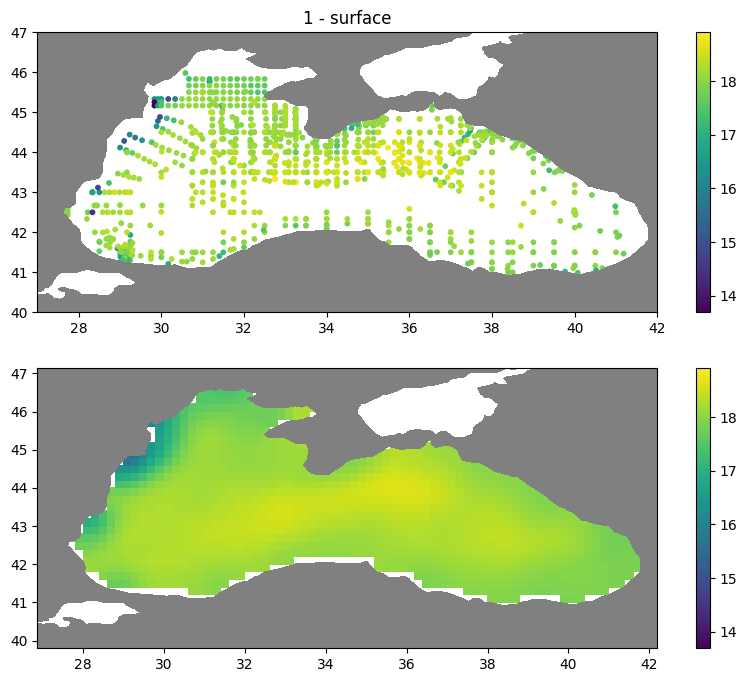

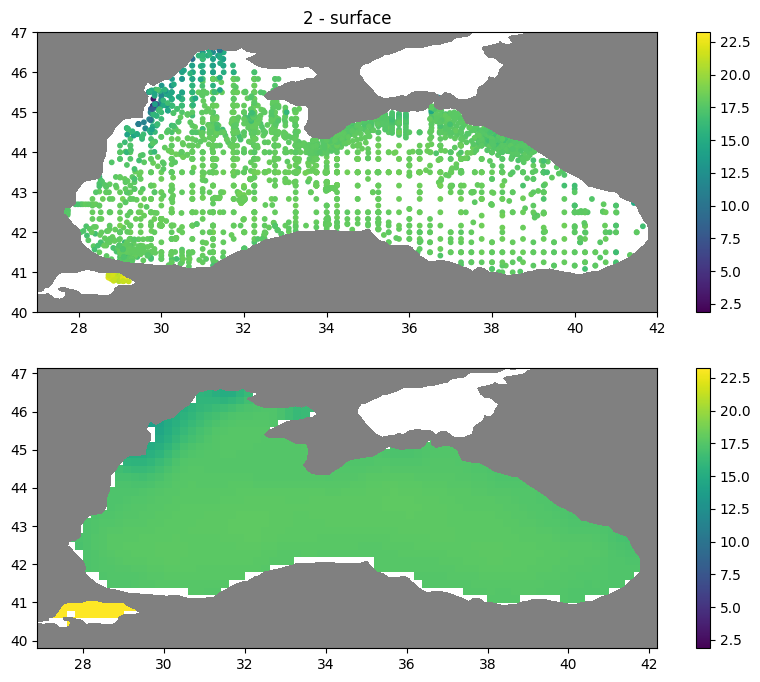

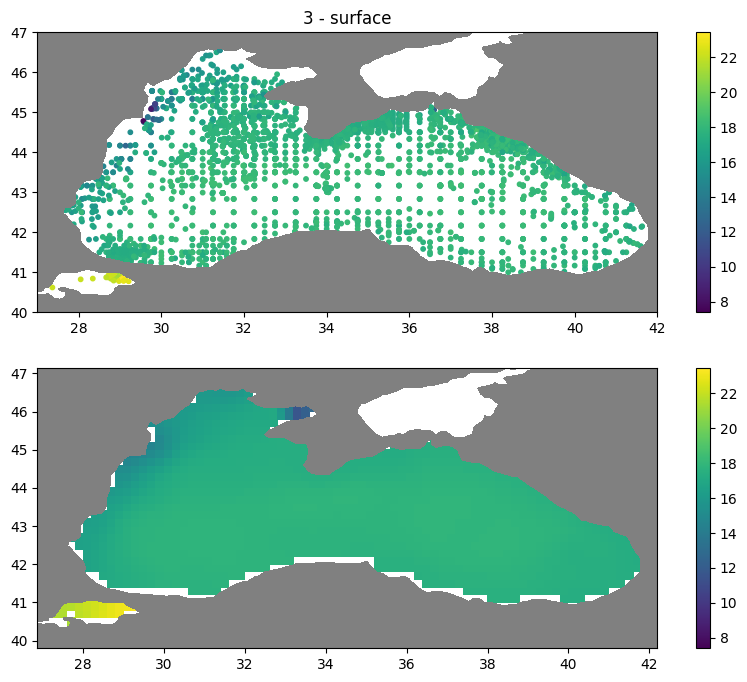

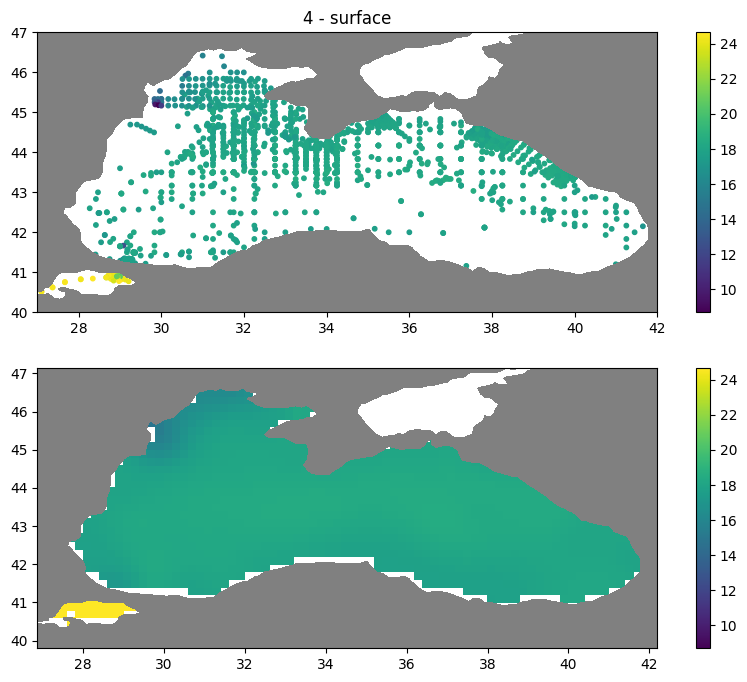

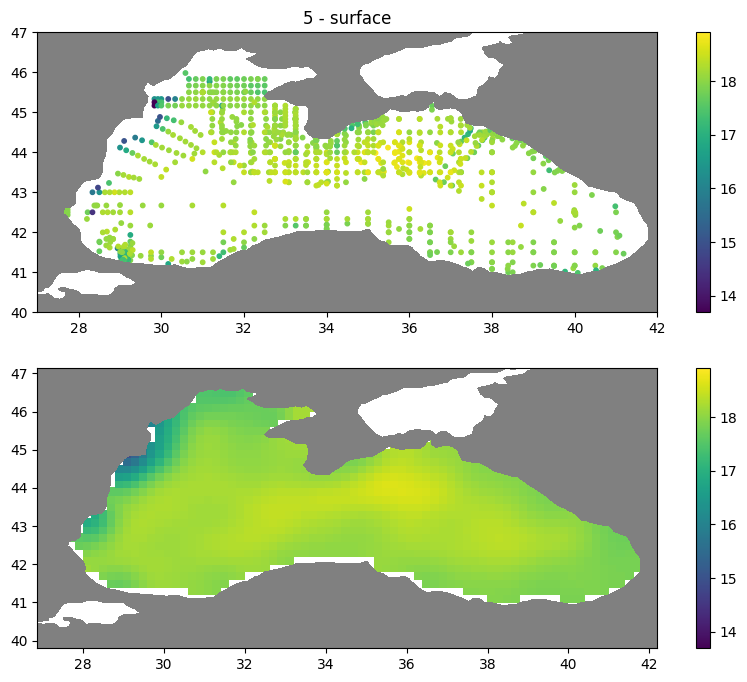

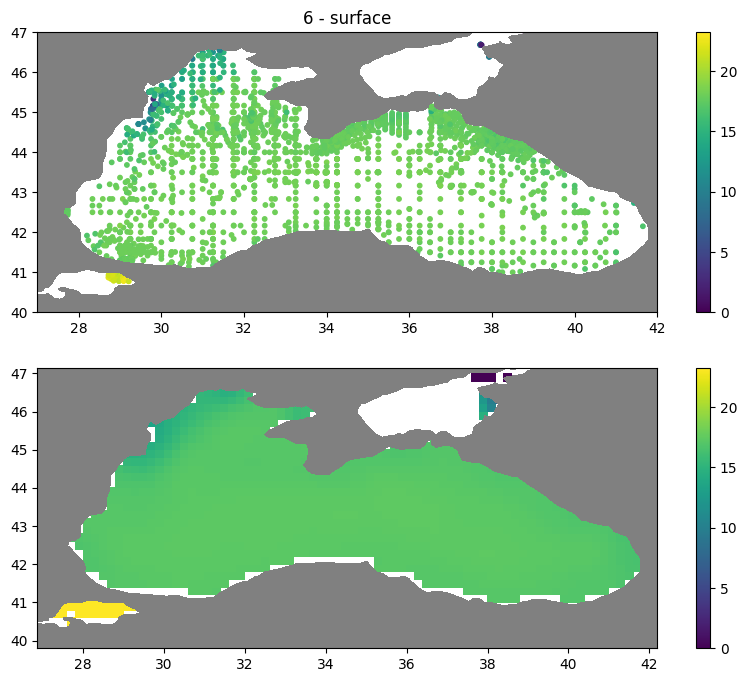

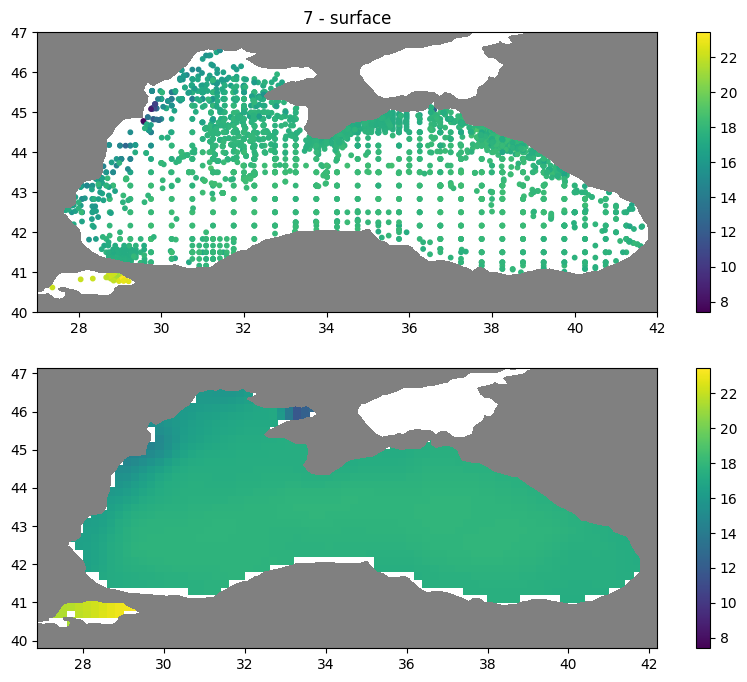

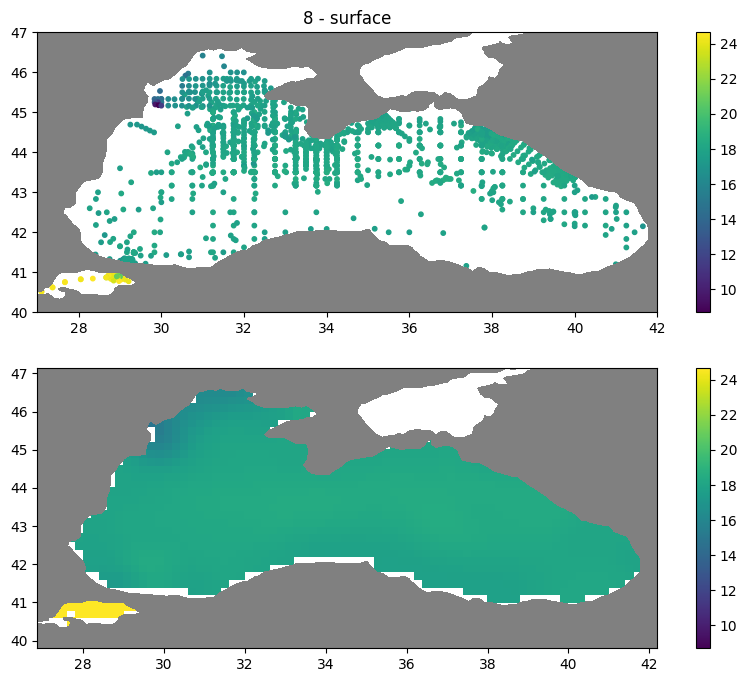

 65.896367 seconds (64.37 M allocations: 5.166 GiB, 3.73% gc time)


139230-element Array{Float64,1}:
  -0.139475 
  -0.711073 
  -1.08267  
  -1.52578  
   0.330534 
   0.0406051
  -0.245324 
   0.0632198
  -0.131494 
 NaN        
 NaN        
 NaN        
 NaN        
   ⋮        
 NaN        
 NaN        
 NaN        
 NaN        
 NaN        
 NaN        
 NaN        
   0.101614 
  -0.0925432
   0.220299 
  -0.0194922
  -0.204075 

In [20]:
if isfile(filename)
   rm(filename) # delete the previous analysis
end

@time dbinfo = diva3d((lonr,latr,depthr,TS),
              (lon,lat,depth,time),
              value,
              (lenx,leny,lenz),
              epsilon2,
              filename,varname,
              bathname = bathname,
              bathisglobal = bathisglobal,
              plotres = plotres,
              ncvarattrib = ncvarattrib,
              ncglobalattrib = ncglobalattrib,
              timeorigin = timeorigin
       )


residual = dbinfo[:residuals]

This generates many plots (one for every time instance). The number in the title is the time index starting with the first season and year.


Save the observation metadata in the NetCDF file

In [22]:
divand.saveobs(filename,(lon,lat,depth,time),ids)

In [23]:
dbinfo

Dict{Symbol,Any} with 1 entry:
  :residuals => [-0.139475, -0.711073, -1.08267, -1.52578, 0.330534, 0.0406051,…

# Residuals

Range of the residuals

In [25]:
# residuals with NaNs removed

res = residual[.!isnan.(residual)]

@show extrema(res);
@show quantile(res,[0.01,0.99]);


extrema(res) = (-14.198290824890137, 2.7844820991999996e10)
quantile(res, [0.01, 0.99]) = [-0.775162, 0.633773]


In [29]:
i = findfirst(minimum(res) .== residual)
ids[i]

"Cruise:WOD05_RU000295-11205173-38.7500-46.890"

For future analysis the residuals can also be saved.

In [30]:
resname = filename = "Water_body_$(replace(varname,' ','_')).residuals.nc"

if isfile(resname)
   rm(resname)
end
divand.saveobs(resname,"$(varname)_residual",residual,(lon,lat,depth,time),ids)

* Visualize the residuals (observations minus analysis)
* Change depth and time
* Adjust colorbare range (`clim`) to see large residuals

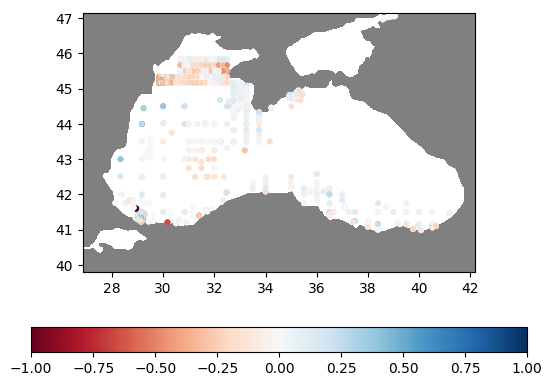

Number of data points: 1378

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5bec3d5f10>

In [33]:
sel = (depth .<  50) .& (Dates.month.(time) .== 1)
print("Number of data points: $(sum(sel))")
contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])
scatter(lon[sel],lat[sel],10,residual[sel]; cmap="RdBu")
clim(-1,1)
# compute and set the correct aspect ratio
aspect_ratio = 1/cos(mean(latr) * pi/180)
gca()[:set_aspect](aspect_ratio)
colorbar(orientation = "horizontal")

## XML metadata

For DIVAnd analysis using SeaDataCloud/EMODnet-Chemistry data, one can create a XML description for the product for Sextant

Name of the project ("SeaDataCloud" or "EMODNET-chemistry")

In [34]:
project = "SeaDataCloud";

Download CDI list

In [35]:
cdilist = "CDI-list-export.zip"

if !isfile(cdilist)
   download("http://emodnet-chemistry.maris2.nl/download/export.zip",cdilist)
end

If `ignore_errors` is `false` (default), then a missing CDI will stop the creatation of the XML metadata.

In [86]:
ignore_errors = true

# File name based on the variable (but all spaces are replaced by _)
xmlfilename = "Water_body_$(replace(varname,' ','_')).4Danl.xml"

"Water_body_Salinity.4Danl.xml"

Uncomment the following line of you are using SeaDataCloud or EMODnet-Chemistry data.

In [87]:
# generate a XML file for Sextant (only for )
#divadoxml(filename,varname,project,cdilist,xmlfilename,
#          ignore_errors = ignore_errors)